# Foundations of Computer Science project
## Paolo Lindia (860507), Fabio Pasquale Lombardi (860550), Pietro Carmine Valenti (807548)

Il progetto utilizza i dati provenienti dal database Kiva (https://www.kaggle.com/gaborfodor/additional-kiva-snapshot) nel quale vengono fornite informazioni su circa 1.4 milioni di prestiti e su circa 2.3 milioni di prestatori da tutto il mondo; i dati sono raccolti in 7 tabelle csv (loans.csv ,lenders.csv, loans_lenders.csv, country_stats.csv, GEconV4.csv, locations.csv, loan_coords.csv). Il progetto, interamente sviluppato su jupyter notebook e utilizzando solo i dati forniti, si divide in celle di codice commentate e markdown, nel quale vengono descritti i passaggi e i processi decisionali. Le celle di codice con solo commenti mostrano dei passaggi che hanno permesso di attuare riflessioni riguardo le question, ma che non sono strettamente necessarie per la soluzione.

In [1]:
import autotime
import datetime
%load_ext autotime
start= datetime.datetime.now()
# La funzione autotime permette di visualizzare in output il tempo di esecuzione di ogni cell 

In [2]:
import seaborn as sea
import matplotlib.pyplot as plt

time: 23.7 s


## Question 1:

### - Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.

Per prima cosa è necessario importare la libreria pandas, la quale consente di importare e gestire i file csv in dataframe; così facendo è possibile importare il file csv loans_lenders in un dataframe

In [3]:
import pandas as pd
loans_lenders=pd.read_csv('loans_lenders.csv')

time: 12.1 s


Per ristrutturare il csv in maniera da ottenere su ciascuna riga un solo codice del prestito (loan_id) e un solo prestatore (lender) utilizziamo un ciclo che separa la colonna non strutturata dei lender con il separatore ', ', in modo da ottenere una lista di lenders per ciascuno loan_id. A questo punto, con il ciclo interno, vengono aggiunti, per ogni valore nella lista lender, il loan_id e il lender in due liste. 

In [4]:
li=[]
le=[]
j=0
for el in loans_lenders['loan_id']:
    x=loans_lenders['lenders'][j].split(', ')
    for l in x:
        li.append(int(el))
        le.append(l)
    j+=1

time: 1min 3s


A questo punto si crea un nuovo dataframe (dfLend) aggungendo le due liste alle colonne loan_id e lenders, ottenendo così un dataframe con 28293912 righe, ciascune delle quali composta da un lender e dal loan_id corrispondente al prestito cui ha partecipato.

In [5]:
dfLend=pd.DataFrame(columns=['loan_id','lenders'])
dfLend['loan_id']=li
dfLend['lenders']=le

time: 22.6 s


La numerosità dei lender nei vari prestiti è estremamente variabile, e va da un minimo di 1 (nel prestito con loan_id 95), fino ad un massimo di 2888 (nel prestito con loan_id 1433600); stessa situazione vale anche per la numerosità dei lenders, la quale va da un minimo di 1 prestito finanziato (per esempio 00mike00), fino ad un massimo di 177645 (gooddogg1)

In [6]:
# sizeXloan=dfLend.groupby('loan_id').size()
# print(sizeXloan.idxmax(),': ',sizeXloan.max(),' | ',sizeXloan.idxmin(),': ',sizeXloan.min())
#   1433600 :  2888  |  95 :  1
# sizeXlend=dfLend.groupby('lenders').size()
# print(sizeXlend.idxmax(),': ',sizeXlend.max(),' | ',sizeXlend.idxmin(),': ',sizeXlend.min())
#   gooddogg1 :  177645  |  00mike00 :  1

time: 4 ms


## Question 2:

### - For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time. If any of those two dates is missing, also the duration must be missing.

Poichè le informazioni necessarie alla soluzione del punto si trovano in loans.csv, importiamo il file in un dataframe pandas.

In [7]:
loans=pd.read_csv('loans.csv',low_memory=False,parse_dates=['disburse_time','planned_expiration_time'])

time: 1min 16s


In [ ]:
#loans.columns
#Index(['loan_id', 'loan_name', 'original_language', 'description',
#       'description_translated', 'funded_amount', 'loan_amount', 'status',
#       'activity_name', 'sector_name', 'loan_use', 'country_code',
#       'country_name', 'town_name', 'currency_policy',
#       'currency_exchange_coverage_rate', 'currency', 'partner_id',
#       'posted_time', 'planned_expiration_time', 'disburse_time',
#       'raised_time', 'lender_term', 'num_lenders_total',
#       'num_journal_entries', 'num_bulk_entries', 'tags', 'borrower_genders',
#       'borrower_pictured', 'repayment_interval', 'distribution_model'],
#      dtype='object')

In [9]:
#type(loans['disburse_time'][0]) = pandas._libs.tslibs.timestamps.Timestamp

time: 52.8 ms


Essendo il dataframe molto grande, ne creiamo uno nuovo mantenendo il loan_id, disburse_time e planned_expiration_time; a questo punto aggiungiamo una colonna Duration, data dalla differenza tra planned_expiration_time e disburse time. Essendovi dei missing values per entrambe le date, la Duration di tali loan sarà anch'essa NaT

In [10]:
lo=pd.DataFrame(columns=['loan_id','Disburse Time','Planned Exp'])
lo['loan_id']=loans['loan_id']
lo['Disburse Time']=loans['disburse_time']
lo['Planned Exp']=loans['planned_expiration_time']
lo['Duration']=lo['Planned Exp']-lo['Disburse Time']

time: 484 ms


In [11]:
type(lo['Duration'][0])

pandas._libs.tslibs.timedeltas.Timedelta

time: 11.9 ms


A questo punto, avendo la duration espressa come una variabile timedelta, utilizziamo i secondi per trovare una valore dei giorni espresso come float (tenendo in tal modo traccia anche delle frazioni di giorno intercorse), creiamo la variabile DurationNum e infine la aggiungiamo al dataframe.

In [12]:
import datetime as  dt
lo['DurationNum']=round(lo['Duration'].dt.total_seconds() / (24 * 60 * 60),2)
lo['DurationNum'].head(10)

0    53.81
1    96.60
2    37.55
3    34.80
4    57.92
5    35.77
6    31.99
7    46.08
8    33.67
9    68.24
Name: DurationNum, dtype: float64

time: 423 ms


L'istogramma sottostante mostra la distribuzione della duration dei diversi prestiti. Si può notare come la duration di gran parte dei prestiti si concentri tra 0 e 100 giorni, con alcuni prestiti con duration negativa (prestiti che sono stati finanziati dopo la scadenza pianificata) e con duration molto lunga (fino a 1500 giorni). In generale si evince una distribuzione molto asimmetrica

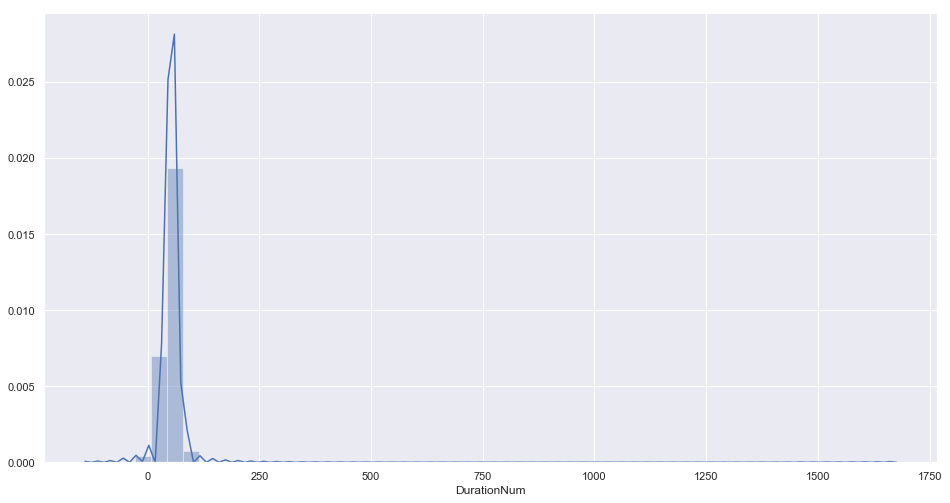

time: 1.44 s


In [13]:
sea.set(rc={'figure.figsize':(16,8.27)})
sea.distplot(lo['DurationNum'][lo['DurationNum'].isna()==False],)

All'interno della colonna DurationNum vi sono 14395  valori negativi e 374645 missing values

In [ ]:
# len(lo[lo['DurationNum']<0])     
# lo['DurationNum'].isnull().sum() 

In [15]:
#1419607-len(loans_lenders)
##ci sono 32175 loan che compaiono in loans e non in loans_lenders

time: 906 ms


In [16]:
#loans['loan_id'][loans['funded_amount']==0]
###2568 loan non sono presenti in loans_lenders, hanno fundend=0 e num_lenders=0

time: 116 ms


## Question 3:

### - Find the lenders that have funded at least twice.

Per calcolare quante volte ha contribuito ogni lender utilizziamo una groupby sul dataframe dfLend (creato al punto 1) sulla colonna lenders.

In [17]:
numFund=dfLend.groupby('lenders').size()
numfund=numFund.reset_index()
numfund.columns=['lenders','count']

time: 14.3 s


Utilizziamo un cut-off a 2 sulla colonna count in maniera da ottenere una tabella con inclusi solo i lenders che hanno finanziato almeno 2 volte (i quali risultano 901811 su 1383799)

In [18]:
more2Fund=numfund[numfund['count']>1]
more2Fund.head()

,lenders,count
0,000,40
1,00000,39
2,0002,70
4,0101craign0101,71
5,0132575,4


time: 536 ms


In [19]:
#len(numFund)   --> 1383799
#len(more2Fund) --> 901811

time: 64 ms


## Question 4:

### - For each country, compute how many loans have involved that country as borrowers

Per ottenere il numero di prestiti che hanno coinvolto ciascuna nazione (in quanto prestatori), basta utilizzare una groupby sul dataframe loans, utilizzando la colonna country_code, per ottenere la dimensione. Abbiamo deciso di utilizzare il country_code al posto di country_name poichè ci consente di collegarci più facilmente alla tabella country_stats, che abbiamo utilizzato come tabella di riferimento per ciò che riguarda le informazioni geografiche.

In [20]:
BorXCountry=loans.groupby('country_code').size()

time: 253 ms


Mettiamo le informazioni ottenute in un dataframe

In [21]:
BorXCountry=pd.DataFrame(BorXCountry.reset_index().rename(columns={0:'num_borrowers'}))
BorXCountry.head(10)

,country_code,num_borrowers
0,AF,2337
1,AL,3075
2,AM,13952
3,AZ,10172
4,BA,608
5,BF,3489
6,BG,296
7,BI,1727
8,BJ,5946
9,BO,25250


time: 80 ms


Text(0.5, 1.0, 'Barplot con numero di borrowers per nazione')

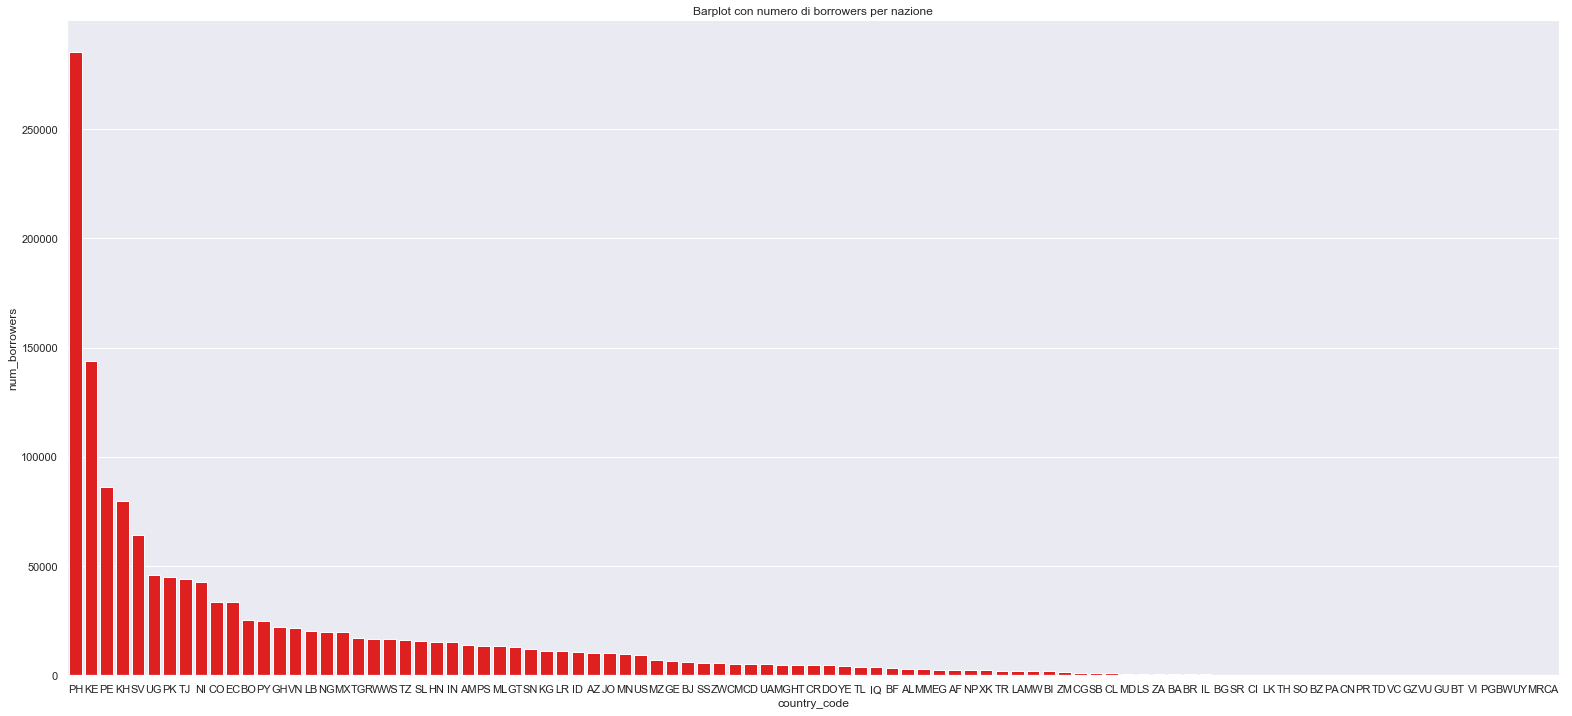

time: 2.4 s


In [22]:
sea.catplot("country_code","num_borrowers", data=BorXCountry.sort_values('num_borrowers',ascending=0),kind="bar",height=10, aspect=2.2,color='red')
plt.title('Barplot con numero di borrowers per nazione')

## Question 5 :

### - For each country, compute the overall amount of money borrowed

Importiamo il file country_stats.csv in un dataframe, al fine di utilizzarlo per 'pulire' i dati dai country_code che non appartengono a tale tabella

In [23]:
country_stats=pd.read_csv('country_stats.csv')

time: 40 ms


L'unico country_code mancante in country_stats è quello della Namibia; poichè nella tabella loan vi sono prestiti riferiti a borrower della Namibia, imputiamo i l country_code mancante con la stirnga 'NA' (non utilizzata per altri country_code) 

In [24]:
# country_stats[country_stats['country_code'].isnull()]
# loans[loans['country_name']=='Namibia']

time: 113 ms


In [25]:
country_stats['country_code']=country_stats['country_code'].mask(country_stats['country_name'].isin(['Namibia']),
                                                                 country_stats['country_code'].fillna('NA'))

loans['country_code']=loans['country_code'].mask(loans['country_name'].isin(['Namibia']),
                                                                 loans['country_code'].fillna('NA'))

time: 415 ms


Risolto il problema del country_code della namibia si può passare all'esercizio. Abbiamo deciso di utilizzare la variabile funde_amount al posto di loan_amount poichè le abbiamo interpretate rispettivamente come ammontare finanziato e ammontare richiesto (il fatto che il secondo sia sempre maggiore del primo avvalora la tesi); seguendo questo ragionamento l'ammontare preso in prestito da ciascuna nazione viene inteso la quantità di denaro che effettivamente hanno ricevuto.

In [26]:
amount=pd.DataFrame(columns=['loan_id','country_code','funded_amount'])
amount['loan_id']=loans['loan_id']
amount['country_code']=loans['country_code']
amount['funded_amount']=loans['funded_amount']
amount.head()

,loan_id,country_code,funded_amount
0,657307,PH,125.0
1,657259,HN,400.0
2,658010,PK,400.0
3,659347,KG,625.0
4,656933,PH,425.0


time: 304 ms


Avendo utilizzato country_stats come tabella di riferimento per i dati geografici, notiamo che vi sono 5 ountry_code che compaiono in loans e non in country_stats: [GZ, VC, VI, VU, GU]; analizzando tali codici si nota che si riferiscono a zone con geografie politiche particolari, o comunque confuse (GZ=Gaza, in teoria territorio palestinese, VI=Virgin islands, in teoria americane, britanniche e portoricane). Essendo solo 34 osservazioni,con valori NaN su molte variabili, optiamo per eliminarle.

In [27]:
nomatchcodes=[x for x in list(amount['country_code'].unique()) if x not in list(country_stats['country_code'])]
nomatchcodes

['GZ', 'VC', 'VI', 'VU', 'GU']

time: 80.4 ms


In [28]:
for el in range(0,5):
    rows=list(amount.loc[amount['country_code']==nomatchcodes[el]].index)
    amount=amount.drop(rows)#cancelliamo le righe con i non match codes

time: 1.52 s


In [29]:
amount=amount.reset_index()
del amount['index'] ##resetto gli indici che erano stati cancellati

time: 76 ms


Una volta puliti i country_code è possibile calcolarsi la somma dei funded_amounts per ciascuna nazione (individuata dai country_code)

In [30]:
amBorXCountry=amount[['country_code','funded_amount']].groupby('country_code').sum()
amBorXCountry=pd.DataFrame(amBorXCountry).reset_index()
amBorXCountry.head(10)

,country_code,funded_amount
0,AF,1964650.0
1,AL,3992475.0
2,AM,20284675.0
3,AZ,14191350.0
4,BA,477250.0
5,BF,4042950.0
6,BG,375300.0
7,BI,5119300.0
8,BJ,3829925.0
9,BO,41814950.0


time: 1.01 s


Text(0.5, 1.0, 'Barplot con ammontare borrowed per nazione')

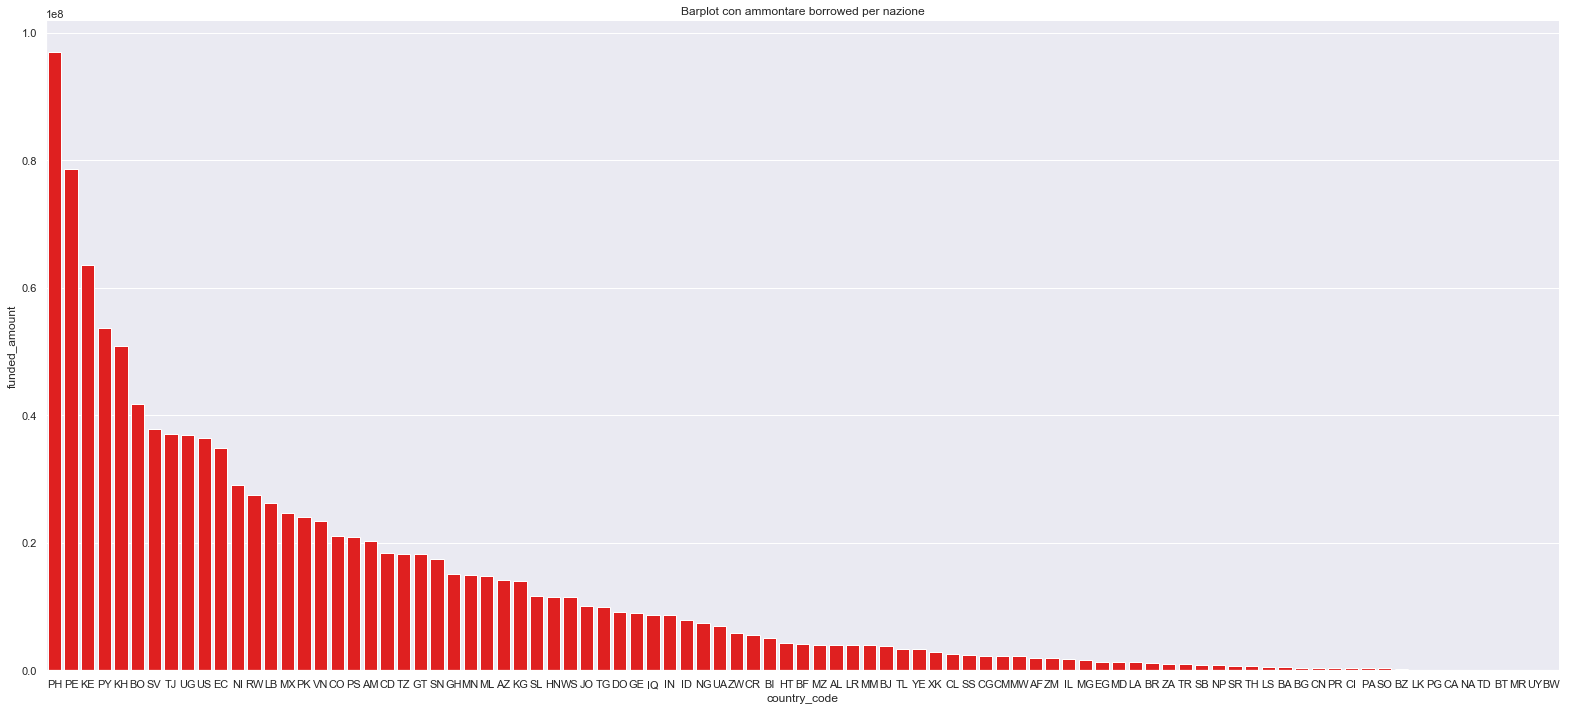

time: 2.82 s


In [31]:
sea.catplot("country_code","funded_amount", data=amBorXCountry.sort_values('funded_amount',ascending=0),kind="bar",height=10, aspect=2.2,color='red')
plt.title('Barplot con ammontare borrowed per nazione')

## Question 8:

### - For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount

Abbiamo deciso di spostare il punto 8 prima del 6 e del 7 in quanto necessario per entrambi.
Per imputare a ciascun lender l'ammontare di prestito che ha finanziato assumiamo (come da consegna) che ciascun lender contribuisca egualmente; il primo passo è quindi il calcolo del numero dei lenders su ogni loan_id. Poichè il numero di lenders ricavabile da loans_lender è diverso da quello ricavabile da loans (colonna num_lenders_total), decidiamo di utilizzare il primo (calcolandolo con una groupby su loan_id)

In [32]:
numlend=pd.DataFrame(dfLend.groupby(dfLend['loan_id']).size()).reset_index().rename(columns={0:'Size'})

time: 1.67 s


A questo punto utilizziamo una merge per aggiungere a ciascuna riga loan_id-lender, una colonna con il numero di lender che partecipano al prestito considerato

In [33]:
dfLend=pd.merge(dfLend,numlend)

time: 6.38 s


Stessa cose per aggiungere una colonna con i funded_amount relativi al prestito considerato

In [34]:
dfLend=pd.merge(dfLend,loans[['loan_id','funded_amount']])

time: 5.62 s


Infine creiamo una nuova variabile (per capita) data dal valore del funde_amount fratto il numero di lenders che partecipano al prestito

In [35]:
dfLend['per_capita']=dfLend['funded_amount']/dfLend['Size']

time: 347 ms


Infine con una groupby otteniamo la quantità totale di finanziamenti per ciascun lender

In [36]:
perCapita=dfLend[['lenders','per_capita']].groupby('lenders').sum()
perCapita.head(10)
# Totale di denaro prestato da ciascun lender

,per_capita
lenders,
000,1703.868411
00000,1379.750248
0002,2472.563566
00mike00,52.631579
0101craign0101,2623.565117
0132575,117.678140
0154884,136.342116
0161130,74.779412
0169713,128.839390


time: 17.7 s


Text(0.5, 1.0, '10 lenders che hanno finanziato le somme maggiori')

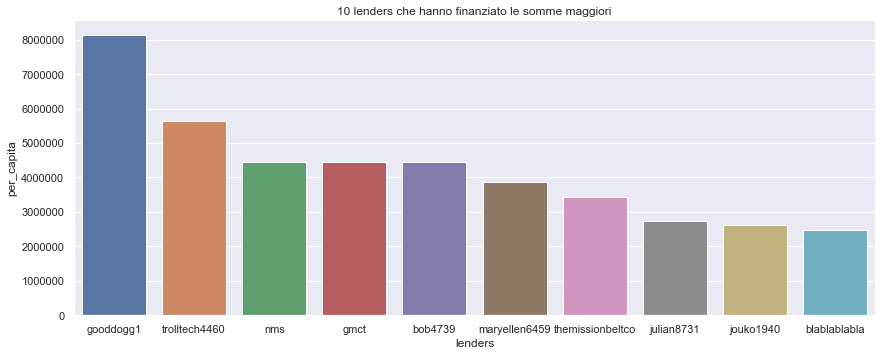

time: 1.27 s


In [37]:
sea.catplot("lenders","per_capita", data=pd.DataFrame(perCapita).reset_index().sort_values('per_capita',ascending=False).head(10),kind="bar", aspect=2.5)
plt.title('10 lenders che hanno finanziato le somme maggiori')

## Question 6:

### - Like the previous point (5), but expressed as a percentage of the overall amount lent.

La consegna richiede il calcolo della percentuale di ammontare dei prestiti che hanno coinvolto ciascuna nazione come richiedente, sull'ammontare che l'hanno vista convolta come prestatrice. Importiamo la tabella lenders, la quale ha le informazioni riguardanti i prestatori (tra cui la nazionalità).

In [38]:
lenders=pd.read_csv('lenders.csv')

time: 5.19 s


Per prima cosa risolviamo il problema del country_code della Namibia, imputando con la stringa 'NA' all'unico lender che ha partecipato ad un prestito (ckqdm1115)

In [ ]:
# lenders[lenders['state']=='Namibia']
# dfLend[dfLend['lenders']=='jakeskaova9324']
# dfLend[dfLend['lenders']=='doreen3422']
# dfLend[dfLend['lenders']=='ckqdm1115']

In [40]:
lenders['country_code']=lenders['country_code'].mask(lenders['state'].isin(['Namibia']),
                                                     lenders['country_code'].fillna('NA'))
# imputazione di country_code per i lender della Namibia

time: 942 ms


Il primo grande problema riguarda le discrepanze tra i country_code presenti nel dataframe lenders: infatti sono presenti 235 country_code (quasi 40 in più delle nazioni esistenti), contro i 174 presenti in country_stats. Utilizzando sempre country_stats come riferimento settiamo a missing i country_code non presenti.

In [41]:
a=list(lenders['country_code'].unique())
len(a) #235 country code in lenders, più delle 174 nazioni in country_stats
c=pd.DataFrame(a,columns=['country_code'])

time: 160 ms


In [42]:
b=c.merge(country_stats[['country_code','country_name']],on='country_code')

time: 92 ms


Mettiamo i country_code non presenti in stats in una lista

In [43]:
linomatch=[]
for el in lenders['country_code'].unique(): 
    if pd.isnull(el)==False:
        if not el in country_stats['country_code'].unique():
            linomatch.append(el)
len(linomatch) ##64             

64

time: 297 ms


Si può subito notare come i lenders con country_code presente nella lista nomatch hanno numerose irregolarità; per esempio il code AD corrisponde a nazioni: asdkjl, Andorra, Barcellona, KS...che chiaramente non sono nazioni. La soluzione è settarli a NaN

In [44]:
#lenders[lenders['country_code']==linomatch[3]]

time: 40 ms


In [45]:
country_code=[]
for el in lenders['country_code']:
    if el in linomatch:
        a=float('nan')
    else:
        a=el
    country_code.append(a) ##setto a nan i country_code che non coincidono con quelli di stats

time: 4.89 s


Per imputare i valori macanti di country_code per la tabella lenders utilizziamo un metodo basato sulla probabilità di occorrenza di ciascuno country_code (calcolato sulle osservazioni non missing); in tal modo si riesce a mantenere, con un margine di errore dovuto alla casualità, a mantenere la distribuzione di frequenza campionaria dei country_code. Il campione arà formato dagli 890539 country_code non missing.
Per prima cosa calcoliamo le frequenze assolute di ciascun country_code

In [46]:
lenders['country_code2']=country_code
lendersXcountry=lenders[lenders['country_code']!=float('nan')].groupby('country_code2').size()
length=len(lenders)-sum(lenders['country_code'].isnull())#890539 country_code presenti

time: 1.76 s


Calcoliamo la frequenza relativa di ciascun country_code (dividendo la freq. assoluta per la numerosità totale dei non missing = 890539)

In [47]:
percXcountry=pd.DataFrame(lendersXcountry/length).reset_index().rename(columns={0:'perc'})

time: 3.99 ms


Poichè per l'imputazione casuale serve che le probabilità sommino a 1, normalizziamo le percentuali

In [48]:
percXcountry['perc']=percXcountry['perc']/sum(percXcountry['perc'])

time: 1.01 s


Utilizziamo la funzione di numpy (random.choice), la quale ci permette di imputare valori casualmente, seguendo una data distribuzione di probabilità (data dalla variabile campionaria 'perc'). Il ciclo for mantiene il country_code quando presente e lo  imputa quando è missing.

In [49]:
import random
import numpy as np
random.seed(123)
newcountry=[]
for el in lenders['country_code2']:
    if type(el)==float:
        val=np.random.choice(percXcountry['country_code2'], p=percXcountry['perc'])
    else:
        val=el
    newcountry.append(val)

time: 2min 49s


Imputati i country_code si può passare a unire i dataset dfLend (contenete il valore di loan finanziato procapite), con il dataframe lenders (contenente i country_code completi).

In [50]:
lenders['country_code2']=newcountry
dfLendCountry=dfLend.merge(lenders[['permanent_name','country_code2']],left_on='lenders',right_on='permanent_name')

time: 33.1 s


In [51]:
del dfLendCountry['permanent_name']

time: 481 ms


Con una groupby su country_code calcoliamo il valore totale dei finanziamenti (intesi somma dell'ammontare procapite di ciascun lender) provenienti da ciascuna nazione.

In [52]:
amLendXCountry=pd.DataFrame(dfLendCountry[['country_code2','per_capita']].groupby('country_code2').sum()).reset_index()
amLendXCountry['country_code']=amLendXCountry['country_code2']
del amLendXCountry['country_code2']

time: 8.48 s


Essendovi una nazione (CHAD,TD) che compare in loans ma non in lenders, optiamo per una left join, in modo da non avere percentuali impossibili da calcolare (20075/NaN o 20075/0).

In [53]:
# amXCountry=pd.merge(amLendXCountry,amBorXCountry,how='outer') -->  [171	NaN	TD	20075.0]
amXCountry=pd.merge(amLendXCountry,amBorXCountry,how='left')
amXCountry.head(10)

,per_capita,country_code,funded_amount
0,1.915322e+06,AE,NaN
1,1.570816e+05,AF,1964650.0
2,2.582410e+04,AL,3992475.0
3,3.815660e+04,AM,20284675.0
4,3.966385e+04,AO,NaN
5,2.079591e+06,AR,NaN
6,3.063531e+06,AT,NaN
7,5.908935e+07,AU,NaN
8,1.452093e+04,AZ,14191350.0
9,6.877971e+04,BA,477250.0


time: 100 ms


Settiamo a 0 i valori NaN di lended_amount e borrowed_amount, poichè indicano che la nazione non ha mai finanziato o richiesto in prestito. Calcoliamo infine la percentuale (espressa come (lended_amount/borrowed_amount)*100) per ciascuna nazione

In [54]:
pd.options.display.float_format = '{:.2f}'.format
# settiamo a 0 i NaN presenti in borrowed_ammount, poichè essi segnalano nazioni che hanno finanziato, ma non hanno mai
# richiesto in prestito denaro (quindi hanno borrowed_amount=0)
amXCountry=amXCountry.fillna(0)
amXCountry=amXCountry.rename(columns={'per_capita':'lended_amount',
                          'funded_amount':'borrowed_amount'})
amXCountry['perc']=amXCountry['borrowed_amount']/amXCountry['lended_amount']*100# percentuale di borrowed_am su lended_am
amXCountry=amXCountry[['country_code','borrowed_amount','lended_amount','perc']]
amXCountry.head(10)

,country_code,borrowed_amount,lended_amount,perc
0,AE,0.00,1915321.64,0.00
1,AF,1964650.00,157081.59,1250.72
2,AL,3992475.00,25824.10,15460.27
3,AM,20284675.00,38156.60,53161.64
4,AO,0.00,39663.85,0.00
5,AR,0.00,2079591.17,0.00
6,AT,0.00,3063531.03,0.00
7,AU,0.00,59089351.52,0.00
8,AZ,14191350.00,14520.93,97730.34
9,BA,477250.00,68779.71,693.88


time: 200 ms


## Question 7: 

### - Like the three previous points, but split for each year (with respect to disburse time) (diviso in tre punti)

### Punto 2 (riferito a question 5)

Per prima cosa aggiungiamo una variabile anno (estratta dalla colonna disburse_time della tabella loans)

In [55]:
am=pd.merge(amount,loans[['loan_id','disburse_time']])
am['year']=am['disburse_time'].dt.year
del am['disburse_time']
# creiamo una colonna year estratta da loans.disburse_time 

time: 1.8 s


Utilizziamo una groupby questa volta su country_code e year per calcolare la somma dei finanziamenti per nazione e per anno

In [56]:
borCountryYear=am[['country_code','year','funded_amount']].groupby(['country_code','year']).sum()
borCountryYear.head(10)

funded_amount
country_code year                  
AF           2007.00      194975.00
             2008.00      365375.00
             2009.00      581825.00
             2010.00      563350.00
             2011.00      245125.00
             2015.00        6000.00
             2016.00        8000.00
AL           2012.00      411775.00
             2013.00      780850.00
             2014.00      875225.00

time: 383 ms


### Punto 1 (riferito a question 4)

Calcoliamo utilizzando una groupby (per calcolare la numerosità) per nazione e anno

In [57]:
sizeCountryYear=pd.DataFrame(am.groupby(['country_code','year']).size())
sizeCountryYear.head(10)
# numero di volte in cui una nazione è stata coinvolta come borrower per anno

0
country_code year        
AF           2007.00  408
             2008.00  370
             2009.00  678
             2010.00  632
             2011.00  247
             2015.00    1
             2016.00    1
AL           2012.00  332
             2013.00  507
             2014.00  603

time: 297 ms


### Punto 3 (riferito a Question 7)

Svolgiamo la question 7 tenendo conto questa volta anche dell'anno...

In [58]:
dfLendCountry2=dfLendCountry[['loan_id','per_capita','country_code2']].merge(am[['loan_id','year']])
dfLendCountry2['country_code']=dfLendCountry2['country_code2']
del dfLendCountry2['country_code2']

time: 15.5 s


In [59]:
lendCountryYear=dfLendCountry2[['country_code','per_capita','year']].groupby(['country_code','year']).sum()

time: 5.09 s


In [60]:
borlendCountryYear=borCountryYear.merge(lendCountryYear,right_index=True,left_index=True,how='outer')
borlendCountryYear=borlendCountryYear.fillna(0)
borlendCountryYear=borlendCountryYear.rename(columns={'funded_amount':'borrowed_amount','per_capita':'lended_amount'})
borlendCountryYear['perc']=borlendCountryYear['borrowed_amount']/borlendCountryYear['lended_amount']*100

time: 1.57 s


... ottenendo così borrowed_amount, lended_amount e la percentuale del primo sul secondo, per ogni nazione e anno

In [61]:
borlendCountryYear.head(15)
# dataset con borrowed_amount, lended_amount e percentuale di borrowed/lended per nazione e per anno

borrowed_amount  lended_amount    perc
country_code year                                           
AE           2007.00             0.00       18271.72    0.00
             2008.00             0.00       34424.03    0.00
             2009.00             0.00       72929.37    0.00
             2010.00             0.00       98954.81    0.00
             2011.00             0.00      153999.25    0.00
             2012.00             0.00      210772.15    0.00
             2013.00             0.00      209181.89    0.00
             2014.00             0.00      229826.86    0.00
             2015.00             0.00      253944.16    0.00
             2016.00             0.00      288916.93    0.00
             2017.00             0.00      341423.11    0.00
             2018.00             0.00        1229.89    0.00
AF           2006.00             0.00        2441.41    0.00
             2007.00        194975.00        9275.07 2102.14
             2008.00        365375.00        5981.67 6108.24

time: 12 ms


## Question 9:

### - For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.

Poichè viene richiesta un'operazione simile a quella del punto 6 si utilizza il dataset ottenuto; questa volta viene proposta la differenza tra l'ammontare lended e borrowed per ciascuna nazione

In [62]:
amXCountry['differenceL-B']=amXCountry['lended_amount']-amXCountry['borrowed_amount']
amXCountry.head(10)

,country_code,borrowed_amount,lended_amount,perc,differenceL-B
0,AE,0.00,1915321.64,0.00,1915321.64
1,AF,1964650.00,157081.59,1250.72,-1807568.41
2,AL,3992475.00,25824.10,15460.27,-3966650.90
3,AM,20284675.00,38156.60,53161.64,-20246518.40
4,AO,0.00,39663.85,0.00,39663.85
5,AR,0.00,2079591.17,0.00,2079591.17
6,AT,0.00,3063531.03,0.00,3063531.03
7,AU,0.00,59089351.52,0.00,59089351.52
8,AZ,14191350.00,14520.93,97730.34,-14176829.07
9,BA,477250.00,68779.71,693.88,-408470.29


time: 875 ms


## Question 10:

### - Which country has the highest ratio between the difference computed at the previous point and the population?

Viene calcolato il rapporto tra  la differenza della Question 9 e la numerosità della popolazione, presente in country_stats e senza valori missing.

In [63]:
pd.get_option('display.max_colwidth')
country=country_stats[['country_name','country_code','population','population_below_poverty_line','continent']]
country=pd.merge(amXCountry,country,how='left')
country['ratio']=country['differenceL-B']/country['population']
country[['country_name','country_code','ratio']].head(10)

,country_name,country_code,ratio
0,United Arab Emirates,AE,0.20
1,Afghanistan,AF,-0.05
2,Albania,AL,-1.35
3,Armenia,AM,-6.91
4,Angola,AO,0.00
5,Argentina,AR,0.05
6,Austria,AT,0.35
7,Australia,AU,2.42
8,Azerbaijan,AZ,-1.44
9,Bosnia and Herzegovina,BA,-0.12


time: 615 ms


Dalla nuova tabella si può identificare la nazione con il rapporto più elevato

In [64]:
print('Nazione con il massimo rapporto:','\n',
      'Nazione=',country['country_name'][country['ratio'].idxmax()],
      '|','Country Code=',country['country_code'][country['ratio'].idxmax()],
      '|','Ratio=',round(country['ratio'][country['ratio'].idxmax()],3))

Nazione con il massimo rapporto: 
 Nazione= Norway | Country Code= NO | Ratio= 3.772
time: 92 ms


## Question 11:

### - Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?

Essendovi dei valori mancanti nella variabile pop_below_poverty_line, imputiamo utilizzando la media condizionata per continent (poichè putroppo region ha a sua volta numerosi valori mancanti)

In [65]:
meanCond=country.groupby('continent')['population_below_poverty_line'].mean()
# essendoci numerosi missing values in pop_below_poverty_line imputiamo i valori con le medie condizionate per continente
# (poichè per region non è possibile essendo assenti tutti i valori per le regioni: Polynesia, Australia&Nuova Zelanda)

time: 159 ms


In [66]:
country=country.set_index('continent')
country['population_below_poverty_line']=country['population_below_poverty_line'].fillna(meanCond)
country=country.reset_index()

time: 105 ms


In [67]:
country.head(10)
# si può notare che AU (Australia), la quale è in Oceania, è stata imputata con la media dell'Oceania (34%)

,continent,country_code,borrowed_amount,lended_amount,perc,differenceL-B,country_name,population,population_below_poverty_line,ratio
0,Asia,AE,0.00,1915321.64,0.00,1915321.64,United Arab Emirates,9400145,19.50,0.20
1,Asia,AF,1964650.00,157081.59,1250.72,-1807568.41,Afghanistan,35530081,35.80,-0.05
2,Europe,AL,3992475.00,25824.10,15460.27,-3966650.90,Albania,2930187,14.30,-1.35
3,Asia,AM,20284675.00,38156.60,53161.64,-20246518.40,Armenia,2930450,32.00,-6.91
4,Africa,AO,0.00,39663.85,0.00,39663.85,Angola,29784193,40.50,0.00
5,Americas,AR,0.00,2079591.17,0.00,2079591.17,Argentina,44271041,32.20,0.05
6,Europe,AT,0.00,3063531.03,0.00,3063531.03,Austria,8735453,4.00,0.35
7,Oceania,AU,0.00,59089351.52,0.00,59089351.52,Australia,24450561,34.00,2.42
8,Asia,AZ,14191350.00,14520.93,97730.34,-14176829.07,Azerbaijan,9827589,4.90,-1.44
9,Europe,BA,477250.00,68779.71,693.88,-408470.29,Bosnia and Herzegovina,3507017,17.20,-0.12


time: 148 ms


In [68]:
country['population_over_poverty']=round(country['population']*(1-(country['population_below_poverty_line']/100)))
country.head(10)
## calcolo delle persone sopra la linea di povertà

,continent,country_code,borrowed_amount,lended_amount,perc,differenceL-B,country_name,population,population_below_poverty_line,ratio,population_over_poverty
0,Asia,AE,0.00,1915321.64,0.00,1915321.64,United Arab Emirates,9400145,19.50,0.20,7567117.00
1,Asia,AF,1964650.00,157081.59,1250.72,-1807568.41,Afghanistan,35530081,35.80,-0.05,22810312.00
2,Europe,AL,3992475.00,25824.10,15460.27,-3966650.90,Albania,2930187,14.30,-1.35,2511170.00
3,Asia,AM,20284675.00,38156.60,53161.64,-20246518.40,Armenia,2930450,32.00,-6.91,1992706.00
4,Africa,AO,0.00,39663.85,0.00,39663.85,Angola,29784193,40.50,0.00,17721595.00
5,Americas,AR,0.00,2079591.17,0.00,2079591.17,Argentina,44271041,32.20,0.05,30015766.00
6,Europe,AT,0.00,3063531.03,0.00,3063531.03,Austria,8735453,4.00,0.35,8386035.00
7,Oceania,AU,0.00,59089351.52,0.00,59089351.52,Australia,24450561,34.00,2.42,16137370.00
8,Asia,AZ,14191350.00,14520.93,97730.34,-14176829.07,Azerbaijan,9827589,4.90,-1.44,9346037.00
9,Europe,BA,477250.00,68779.71,693.88,-408470.29,Bosnia and Herzegovina,3507017,17.20,-0.12,2903810.00


time: 171 ms


Si può infine visualizzare e confrontare i due rapporti

In [69]:
country['ratio2']=country['differenceL-B']/country['population_over_poverty']
country[['country_name','country_code','ratio','ratio2']].head(10)

,country_name,country_code,ratio,ratio2
0,United Arab Emirates,AE,0.20,0.25
1,Afghanistan,AF,-0.05,-0.08
2,Albania,AL,-1.35,-1.58
3,Armenia,AM,-6.91,-10.16
4,Angola,AO,0.00,0.00
5,Argentina,AR,0.05,0.07
6,Austria,AT,0.35,0.37
7,Australia,AU,2.42,3.66
8,Azerbaijan,AZ,-1.44,-1.52
9,Bosnia and Herzegovina,BA,-0.12,-0.14


time: 170 ms


## Question 12

### - For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year

Importiamo in un nuovo dataframe le colonne di loans: loan_id, loan_amount, disburse_time e planned_expiration_time

In [70]:
loanXyear=loans[['loan_id','loan_amount','disburse_time','planned_expiration_time']]

time: 192 ms


Dal momento che esistono solamente due loan con sia disburse che planned_expiration mancanti, droppiamo tali righe. Per i prestiti in cui manca solamente una delle due invece imputeremo l'ammontare totale all'anno non missing

In [71]:
loanXyear=loanXyear.drop(loanXyear[(loanXyear['disburse_time'].isnull())
                                   &(loanXyear['planned_expiration_time'].isnull())].index).reset_index()
del loanXyear['index']

time: 343 ms


In [72]:
loanXyear.head(10)

,loan_id,loan_amount,disburse_time,planned_expiration_time
0,657307,125.00,2013-12-22 08:00:00+00:00,2014-02-14 03:30:06+00:00
1,657259,400.00,2013-12-20 08:00:00+00:00,2014-03-26 22:25:07+00:00
2,658010,400.00,2014-01-09 08:00:00+00:00,2014-02-15 21:10:05+00:00
3,659347,625.00,2014-01-17 08:00:00+00:00,2014-02-21 03:10:02+00:00
4,656933,425.00,2013-12-17 08:00:00+00:00,2014-02-13 06:10:02+00:00
5,659605,350.00,2014-01-15 08:00:00+00:00,2014-02-20 02:30:07+00:00
6,660240,125.00,2014-01-20 08:00:00+00:00,2014-02-21 07:50:11+00:00
7,661601,1600.00,2014-01-10 08:00:00+00:00,2014-02-25 09:50:03+00:00
8,661960,350.00,2014-01-23 08:00:00+00:00,2014-02-26 00:10:03+00:00
9,662117,1825.00,2014-01-10 08:00:00+00:00,2014-03-19 13:40:02+00:00


time: 36 ms


Per svolgere l'esercizio ci serviremo di un dizionario le cui chiavi sono gli anni (dal 2005 al 2018) e i valori (settati inizialmete a 0) sono le somme dei valori di ciascun loan, distribuito proporzionalmente negli anni tra disburse e planned.

In [73]:
diz={2005:0,2006:0,2007:0,2008:0,2009:0,2010:0,2011:0,2012:0,
    2013:0,2014:0,2015:0,2016:0,2017:0,2018:0}

time: 110 ms


Creiamo una funzione (daysfromstart) che accetta una data come parametro, e calcola i giorni trascorsi da inizio anno; sarà utile per la suddivisione dei loan quando l'anno di disburse e planned_expiration non coincidono 

In [74]:
def daysfromstart(date, format='%Y%m%d'):
    date = pd.to_datetime(date, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1
print(daysfromstart(loanXyear['planned_expiration_time'][0].tz_localize(None)))

45
time: 249 ms


Creiamo delle variabili di sostegno alla costruzione del dizionario

In [75]:
loanXyear['repayment_period']=loanXyear['planned_expiration_time']-loanXyear['disburse_time']
loanXyear['first_year']=loanXyear['disburse_time'].dt.year
loanXyear['end_year']=loanXyear['planned_expiration_time'].dt.year

time: 351 ms


Il ciclo aggiunge l'ammontare di ciascun loan al dizionario; il funzionamento di tale ciclo viene descritto passaggio per passaggio dai commenti

In [76]:
for el in range(0,len(loanXyear)):
    if pd.isnull(loanXyear['disburse_time'][el]): #se disburse è missing assegna tutto all'anno expiration
        diz[loanXyear['end_year'][el]]+=round(loanXyear['loan_amount'][el],2)
    elif pd.isnull(loanXyear['planned_expiration_time'][el]):#se expiration è missing assegna tutto all'anno disburse
        diz[loanXyear['first_year'][el]]+=round(loanXyear['loan_amount'][el],2)
    else: # se nessuna delle due è missing entra nell else (poichè abbiamo eliminato le 2 obs con entrambi missing)
        timedelta=loanXyear['repayment_period'][el].days
        first_year=loanXyear['first_year'][el]
        end_year=loanXyear['end_year'][el]
        i=first_year
        if first_year==end_year: #se disburse e expired hanno lo stesso anno, si aggiunge direttamente il loan_amount al dizionario
            diz[first_year]+=round(loanXyear['loan_amount'][el],2)
        else: # se non coincidono entra nel ciclo else; se disburse_time è posteriore a planned_expiration_time (14935 volte), tali prestiti
              # non vengono ripartiti.
            while i<=end_year:# in ciascun if si calcolano i giorni e la proporzione di amount per anno
                if i==first_year: 
                    #nell'anno di disburse si calcolano i giorni mancanti al 31/dicembre
                    giorni=365-daysfromstart(loanXyear['disburse_time'][el].tz_localize(None), format='%Y%m%d')
                    amount=(giorni/timedelta)*loanXyear['loan_amount'][el]
                    diz[i]+=round(amount,2)
                elif i==end_year: 
                    #nell'anno di expired si calcolano i giorni trascorsi dall 1/gennaio
                    giorni=daysfromstart(loanXyear['planned_expiration_time'][el].tz_localize(None), format='%Y%m%d')
                    amount=(giorni/timedelta)*loanXyear['loan_amount'][el]
                    diz[i]+=round(amount,2)
                else: 
                    #negli anni di transizione si calcolano 365 giorni
                    giorni=365
                    amount=(giorni/timedelta)*loanXyear['loan_amount'][el]
                    diz[i]+=round(amount,2)
                i+=1 
# I prestiti con disburse_time > planned_expiration_time non vengono contati nel calcolo

time: 6min 47s


Ciò che si ottiene alla fine è quindi il seguente dizionario, in cui vengono sommati i valori dei prestiti, distribuiti tra il 2005-2018 (chiavi del dizionario)

In [77]:
diz

{2005: 102850.0,
 2006: 1376575.0,
 2007: 15446525.0,
 2008: 39423050.0,
 2009: 59689475.0,
 2010: 72609150.0,
 2011: 91663978.48999995,
 2012: 114034537.12999977,
 2013: 125120379.71000063,
 2014: 154211639.18999887,
 2015: 162357303.9499999,
 2016: 162358054.80999947,
 2017: 175191345.52,
 2018: 6262473.349999994}

time: 4 ms


Dalla serie storica dei prestiti si può notare come vi sia stata una crescita costante dal 2005 al 2017 (viene escluso il 2018 poichè non si hanno i dati di tutto l'anno)

Text(0.5, 1.0, "Serie storica dell'ammontare dei prestiti dal 2005-2017 (valori assoluti)")

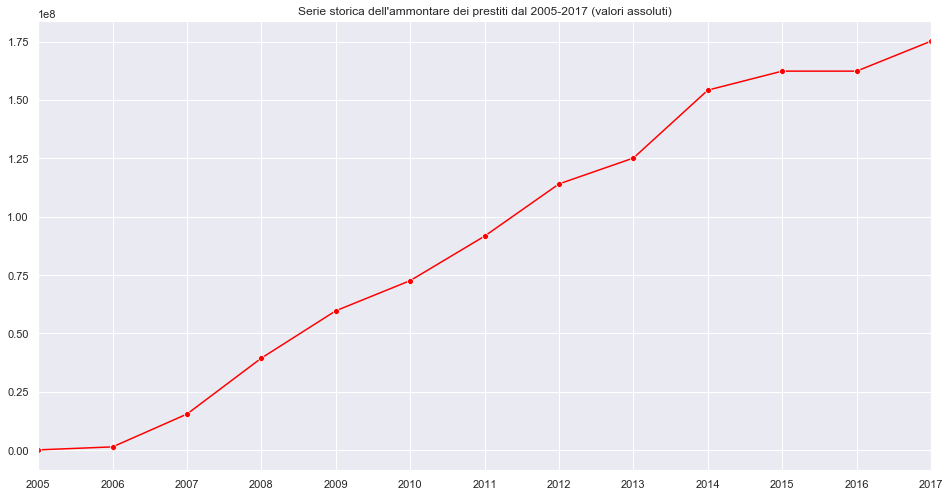

time: 1.1 s


In [78]:
sea.lineplot(list(diz.keys()),list(diz.values()),color='red',marker='o')
plt.xlim(2005,2017)
plt.xticks(list(diz.keys())[0:13])
plt.title("Serie storica dell'ammontare dei prestiti dal 2005-2017 (valori assoluti)")

## Question 13:

### - For each value of repayment_interval, add a new column to the lenders dataframe that contains the total amount of money corresponding to loans in such state

Per lo svolgimento del problema necessitiamo del dataframe dfLend (con loan_id, i lenders e i valori procapite) e della colonna repaayment_interval dal dataframe loans. Applichiamo pertanto una merge con left join, così da mantenere solo i loan_id presenti in dfLend (escludendo quelli non inclusi)

In [79]:
statusloan=pd.merge(dfLend,loans[['loan_id','repayment_interval']],how='left')

time: 7.19 s


Poichè bisogna aggiungere una colonna per ciascuno dei 4 status di repayment_interval (bullet, irregular, monthly, weekly) raggruppiamo il dataframe per leders e repayment_interval, sommando così i valori procapite per ciascun lender e per ciascuno status

In [80]:
statusgroupby=pd.DataFrame(statusloan[['lenders','repayment_interval','per_capita']].groupby(['lenders','repayment_interval']).sum()).reset_index()
statusgroupby.head(10)

,lenders,repayment_interval,per_capita
0,000,bullet,143.34
1,000,irregular,306.65
2,000,monthly,1253.88
3,00000,bullet,106.51
4,00000,irregular,550.24
5,00000,monthly,723.00
6,0002,bullet,209.41
7,0002,irregular,1165.27
8,0002,monthly,1097.88
9,00mike00,monthly,52.63


time: 29.9 s


Applichiamo una merge iterando sui 4 diversi valori assunti da repayment_interval, e prendendo così uno alla volta i 4 subset...

In [81]:
sta=list(statusgroupby['repayment_interval'].unique())
lenders2=lenders
lenders2=lenders2.rename(columns={'permanent_name':'lenders'})
for el in sta:
    subset=statusgroupby[statusgroupby['repayment_interval']==el]
    lenders2=lenders2.merge(subset[['lenders','per_capita']],how='outer')
    lenders2=lenders2.rename(columns={'per_capita':el})
    lenders2[el]=lenders2[el].fillna(0)


time: 28.7 s


...il risultato è pertando una tabella con tutti i lenders, e per ciascuno 4 colonne con la somma del valore prestiti cui hanno partecipato, una per ciascuno status

In [82]:
lenders2[['lenders','bullet','irregular','monthly','weekly']].head(10)

,lenders,bullet,irregular,monthly,weekly
0,qian3013,0.00,46.84,0.00,0.00
1,reena6733,0.00,32.47,385.48,0.00
2,mai5982,0.00,0.00,0.00,0.00
3,andrew86079135,0.00,0.00,158.17,0.00
4,nguyen6962,0.00,0.00,0.00,0.00
5,sirinapa6764,0.00,0.00,50.00,0.00
6,rene7585,0.00,0.00,59.13,0.00
7,harald2826,0.00,32.14,34.38,0.00
8,mehdi2903,0.00,0.00,0.00,0.00
9,youchan8125,0.00,0.00,34.38,0.00


time: 189 ms


Dal grafico si può evnincere che la categoria di repayment_interval con il maggior ammontare (in valore) di prestiti risulta 'monthly'

Text(0.5, 1.0, "Barplot dell'ammontare totale (in denaro) di prestiti diviso per repayment_interval")

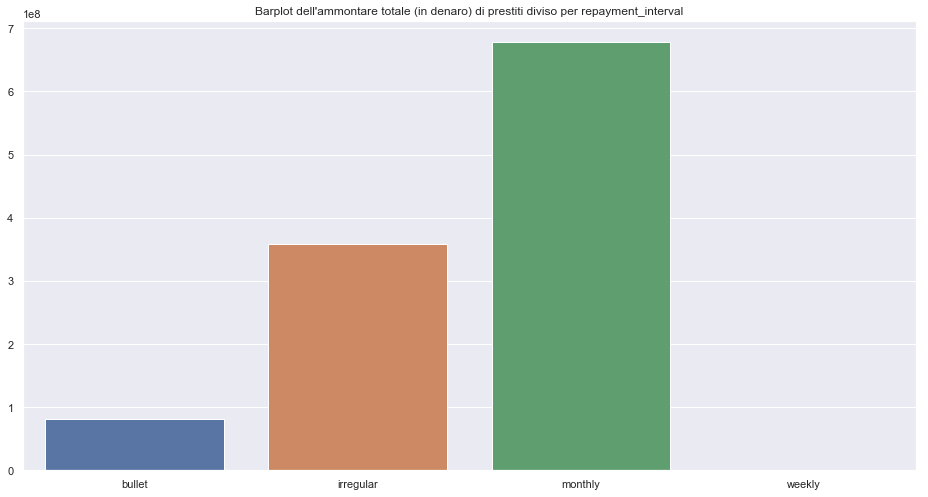

time: 2.01 s


In [83]:
sea.barplot(['bullet','irregular','monthly','weekly'],[sum(lenders2['bullet']),sum(lenders2['irregular']),
                                                       sum(lenders2['monthly']),sum(lenders2['weekly'])])
plt.title("Barplot dell'ammontare totale (in denaro) di prestiti diviso per repayment_interval")

Il grafico dell'ammontare medio mostra una tendenza molto simile, anche se la differenza tra irregular e monthly è molto meno marcata (e così tra bullet e weekly)

Text(0.5, 1.0, "Barplot dell'ammontare medio (in denaro) di prestiti diviso per repayment_interval")

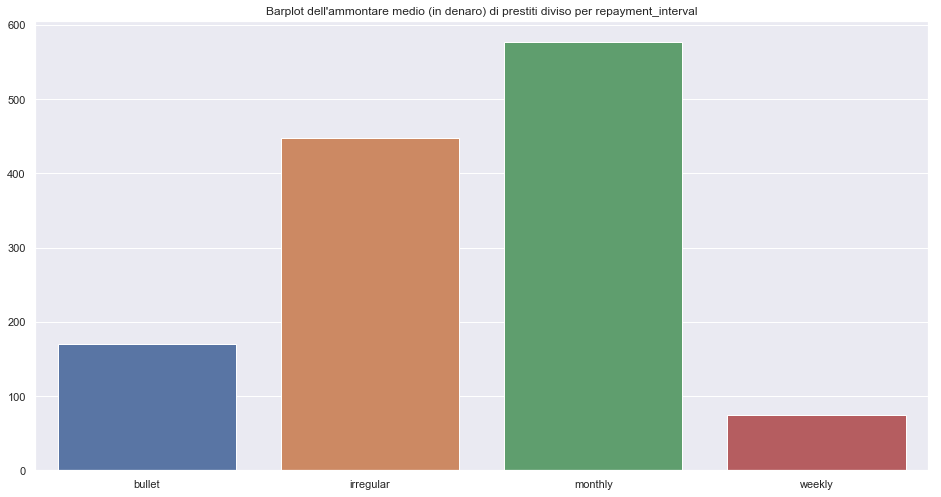

time: 3.73 s


In [84]:
lenders2[lenders2==0]=np.nan
sea.barplot(['bullet','irregular','monthly','weekly'],[np.mean(lenders2['bullet']),np.mean(lenders2['irregular']),
                                                       np.mean(lenders2['monthly']),np.mean(lenders2['weekly'])])
plt.title("Barplot dell'ammontare medio (in denaro) di prestiti diviso per repayment_interval")

## Question 14

### -  What is the occupation with the highest average amount of money lent (the average must be computed over all lenders with a given occupation)?

Le occupazioni di ciascun lender possono essere estratte dal dataframe lenders; la variabile presenta numerose  problematiche tra le quali occupazioni inesistenti (indirizzi web, smile, parole a caso...), caratteri di alfabeti stranieri (cinesi, indiani, arabi...) e blank. Utilizzeremo un metodo basato su espressioni regolari (libreria re) per cercare di pulire i dati.

In [ ]:
import re

Estraiamo le colonne utili (permanent_name e occupation) dal dataframe lenders

In [86]:
occ=pd.DataFrame(lenders[['permanent_name','occupation']].dropna().reset_index())

time: 586 ms


In [87]:
del occ['index']

time: 3.95 ms


In [88]:
#121 numero di occupation che non hanno un nome e che vengono identificate con caratteri che non appartengono 
#ai word characters. Queste occupation verranno trattate come valori mancanti.

time: 746 ms


Utilizziamo l'espressione regolare '^\W+$' per eliminare le occupation con solo simboli, blank, faccine...

In [89]:
pattern='^\W+$'
for i in occ['occupation']:
    if re.match(pattern, i)!=None:
        occ=occ.drop(occ.loc[occ['occupation']==i].index)

time: 20 s


In [90]:
occ=occ.reset_index()
del occ['index']

time: 426 ms


In [91]:
occ=occ.rename(columns={'permanent_name':'lenders'})

time: 252 ms


In [92]:
occ.head(10)

,lenders,occupation
0,vikas1098,Software Engineer
1,jack8790,Business
2,abpestcontrol,Owner
3,oliver8929,Nursing research
4,markeylawfirm,Owner
5,kumari2781,Software Engineer
6,sslcnow,Owner
7,javier7867,Technology Consultant
8,mitalijaykar,Dating Services
9,betterroofing,Owner


time: 139 ms


Uniamo il dataframe appena pulito con quello contenete i contributi procapite dei lenders. Optiamo per una left_join per tenere conto anche dei lenders che non hanno mai finanziato (e che quindi non compaiono in loans_lenders)

In [93]:
lendOcc=occ.merge(dfLend[['lenders','per_capita']].groupby('lenders').sum(), on='lenders', how='left')

time: 23.3 s


Settiamo i valori mancanti a 0 (non hanno mai finanziato)

In [94]:
lendOcc=lendOcc.fillna(0)

time: 153 ms


In [95]:
del lendOcc['lenders']

time: 307 ms


Utilizziamo una groupby per trovare la media per ciascuna occupazione

In [96]:
lendOcc=pd.DataFrame(lendOcc.groupby('occupation').mean()).reset_index().rename(columns={'per_capita':'mean'}).sort_values('mean',ascending=0)

time: 481 ms


In [97]:
lendOcc.head(10)

,occupation,mean
118444,www.linkedin.com/in/peacekeeper,8140650.85
65807,"Retired Pharmacist, Business Owner and Investor",4453652.63
27536,Faith | Care | Evangelism,4445132.22
45644,Making the coolest belts around. No Holes. Alw...,3419770.57
12279,Cat herder,1561503.18
76518,Super Dog,1362488.16
66752,"Retired, so now I volunteer.",1276406.22
83307,Vice President Client Service,1130348.98
10846,CEO of IncParadise.com,1033760.01
33312,Group of Businessmen,940979.64


time: 8 ms


In [98]:
print('- The occupation with the highest average amount of money lent is:', list(lendOcc[lendOcc['mean']==lendOcc['mean'].max()]['occupation'])[0])
print('- where the averege is:', round(float(lendOcc[lendOcc['mean']==lendOcc['mean'].max()]['mean']),2))

- The occupation with the highest average amount of money lent is: www.linkedin.com/in/peacekeeper
- where the averege is: 8140650.85
time: 116 ms


## Question 15

### - Cluster the loans according to the year-month of disburse time.

Per prima cosa estriamo loan_id e disburse_time (variabili necessarie allo svolgimento del punto), e le inseriamo in un nuovo dataframe, in maiera da poter lavorare su una tabella meno onerosa di loans. Eliminiamo le righe con valori mancanti e resettiamo l'indice, in maniera da non avere buchi negli identificativi delle righe.

In [99]:
lo=loans[['loan_id','disburse_time']].dropna().reset_index()
del lo['index']
   

time: 378 ms


In [100]:
lo.head()

,loan_id,disburse_time
0,657307,2013-12-22 08:00:00+00:00
1,657259,2013-12-20 08:00:00+00:00
2,658010,2014-01-09 08:00:00+00:00
3,659347,2014-01-17 08:00:00+00:00
4,656933,2013-12-17 08:00:00+00:00


time: 4 ms


Poichè ci interessail clustering per mese e anno, estraiamo da disburse time tali elementi in formato stringa, non prima di riaverli ordinato le righe per disburse_time

In [101]:
lo=lo.sort_values(by=['disburse_time']) 
lo['month_year']=lo['disburse_time'].dt.strftime("%m/%Y")

time: 36.6 s


Per il raggruppamento in cluster ci serviamo di un dizionario, nel quale avremo come chiavi mese-anno, e come valori delle liste contenenti i loan_id dei prestiti con disburse_time avvenuto in tale mese-anno.

In [102]:
diz2={}
for i in lo['month_year']:  
    if i not in diz.keys():
        diz2[i]=[]

time: 596 ms


In [103]:
k=0
for j in diz2:
    l=[]
    for i in lo['month_year']:
        if i==j:
            l.append(lo['loan_id'][k])
            k+=1
    diz2[j]=l

time: 1min 23s


Possiamo ora mostrare una parte del  dizionario, comprendente la seconda e la terza lista di valori del dizionario, associate rispettivamente alle chiavi  03/2006 e 05/2006

In [104]:
dict(list(diz2.items())[1:3])

{'03/2006': [1153678],
 '05/2006': [1154995,
  1155222,
  1155367,
  1155776,
  1157003,
  1152452,
  1157277,
  1157285,
  1157345,
  1157423,
  1157538,
  1157809,
  1158933,
  1158968,
  1159050,
  1159313,
  252465,
  252846,
  253073,
  253423,
  253469,
  254260,
  1155152,
  252002,
  699882,
  732829,
  741226,
  1147416,
  1190684,
  1199332,
  1199739,
  1208967,
  658016,
  658227,
  658740,
  659272,
  659876,
  660445,
  660642,
  660852,
  663261,
  657977,
  659535,
  660593,
  661368,
  661804,
  663030,
  663116,
  663274,
  651803,
  664794,
  954961,
  955506,
  955893,
  956016,
  956617,
  956754,
  956855,
  957748,
  958171,
  958212,
  958760,
  959169,
  959290,
  960114,
  960511,
  960843,
  960863,
  961060,
  961194,
  962868,
  963073,
  957086,
  958971,
  416476,
  416963,
  417272,
  417381,
  417734,
  417820,
  419798,
  419804,
  420491,
  420521,
  420639,
  420914,
  420966,
  422134]}

time: 20 ms


## Question 16

### - For each country, compute its overall GNI, by multiplying the per capita GNI with its population.

Le informazioni riguardo al GNI si possono ricavare dal dataframe country_stats.

In [105]:
gdpTable=country_stats[['country_code','country_name','continent','gni','population']]
sum(gdpTable.gni.isnull())

6

time: 317 ms


Essendo presenti 6 missing in gni applichiamo nuovamente un imputazione per media condizionata da continent

In [106]:
meanCond2=gdpTable.groupby('continent')['gni'].mean()
gdpTable=gdpTable.set_index('continent')
gdpTable['gni']=gdpTable['gni'].fillna(meanCond)
gdpTable=gdpTable.reset_index()

time: 142 ms


Calcoliamo ora il GNI totale moltiplicando il gni per la popolazione

In [107]:
gdpTable['gni_tot']=round(gdpTable['population']*gdpTable['gni'],2)
gdpTable=gdpTable.sort_values('continent')
gdpTable.head(10)

,continent,country_code,country_name,gni,population,gni_tot
31,Africa,CI,Ivory Coast,3162.74,24294750,76837949748.92
61,Africa,MA,Morocco,7194.92,35739580,257143292451.23
146,Africa,MU,Mauritius,17947.96,1265138,22706651253.73
34,Africa,ZM,Zambia,3463.71,17094130,59209155484.15
123,Africa,GQ,Equatorial Guinea,21517.21,1267689,27277132544.73
143,Africa,DJ,Djibouti,3216.18,956985,3077832219.03
38,Africa,NE,Niger,889.46,21477348,19103148435.41
39,Africa,DZ,Algeria,13532.96,41318142,559156795188.47
40,Africa,MW,Malawi,1073.29,18622104,19986933756.46
41,Africa,ZA,South Africa,12087.21,56717156,685552381625.21


time: 168 ms


Text(0.5, 1.0, 'Barplot con le 10 nazioni con il GNI totale più alto')

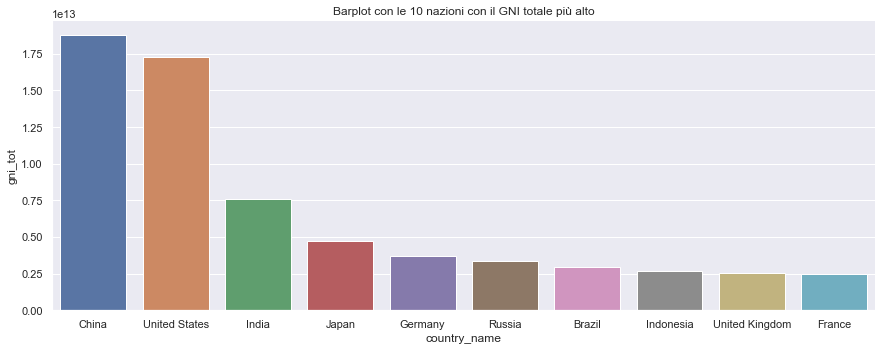

time: 992 ms


In [108]:
sea.catplot("country_name","gni_tot", data=gdpTable.sort_values('gni_tot',ascending=False).head(10),kind="bar",aspect=2.5)
plt.title('Barplot con le 10 nazioni con il GNI totale più alto')

## Question 17

### - Find the country with the highest rate of irregular repayment interval.

Per prima cosa calcoliamo quante volte compaiono le nazioni come borrowers, con una groupby su country_code

In [109]:
sizeCountry=loans[['country_code','repayment_interval']].groupby(['country_code']).size()

time: 213 ms


Ora passiamo a calcolare quante volte occorre ciascuno status di repayment interval per ciascuna nazione, utilizzando una groupby su country_code

In [110]:
sizeRepInt=loans[['country_code','repayment_interval']].groupby(['country_code','repayment_interval']).size()

time: 691 ms


Dividendo le occorrenze di ciascuno status di repayment_interval per le occorrenze totali della nazione, calcoliamo le percentuali di ciascuno status 

In [111]:
percRepInt=(sizeRepInt/sizeCountry)*100

time: 8.01 ms


In [112]:
percRepInt=pd.DataFrame(percRepInt).rename(columns={0:'perc'}).reset_index() ##DataFrame diviso per country_code con le percentuali di ciascun repayment_interval
percRepInt.head(10)

,country_code,repayment_interval,perc
0,AF,bullet,0.09
1,AF,irregular,0.04
2,AF,monthly,99.87
3,AL,bullet,0.98
4,AL,irregular,1.04
5,AL,monthly,97.98
6,AM,bullet,0.77
7,AM,irregular,2.38
8,AM,monthly,96.85
9,AZ,bullet,0.05


time: 272 ms


Dalla tabella si può ora ricavare la nazione con il più altro tasso di irregular repayment_interval, che risulta essere il Bhutan con il 100%

In [113]:
code=percRepInt['country_code'][percRepInt['perc'][percRepInt['repayment_interval']=='irregular'].idxmax()]
percMax=percRepInt['perc'][percRepInt['perc'][percRepInt['repayment_interval']=='irregular'].idxmax()]
print('Country code: ',code)
print('Percentage: ',percMax)

Country code:  BT
Percentage:  100.0
time: 290 ms


Come si può vedere infatti ha due su due prestiti con status irregular

In [114]:
loans[['country_code','repayment_interval']][loans['country_code']=='BT']

,country_code,repayment_interval
781594,BT,irregular
923389,BT,irregular


time: 508 ms


A questo punto, sapendo che il massimo rate è 100%, estraiamo gli altri paesi con percentuale massima, i quali risultano 9

In [116]:
percRepInt[(percRepInt['perc']==100)&(percRepInt['repayment_interval']=='irregular')]

,country_code,repayment_interval,perc
31,BT,irregular,100.00
32,BW,irregular,100.00
35,CA,irregular,100.00
110,LK,irregular,100.00
127,MR,irregular,100.00
153,PG,irregular,100.00
170,SB,irregular,100.00
215,UY,irregular,100.00
222,VU,irregular,100.00


time: 12 ms


## Question 18

### - Find the country with the highest fraction of loaned amount with irregular repayment interval.

Applichiamo la metodologia del punto precedente, questo volta tenendo conto della somma di loan_amount invece che del numero di occorrenze

In [119]:
amLoan=loans.groupby(['country_code','repayment_interval'])['loan_amount'].sum()
## ammontare dei prestiti per ogni nazione e repayment_interval

time: 323 ms


In [117]:
amCountry=loans.groupby(['country_code'])['loan_amount'].sum()
## ammontare dei prestiti per ogni nazione

time: 92 ms


In [120]:
percAmLoan=pd.DataFrame((amLoan/amCountry)*100).reset_index().rename(columns={'loan_amount':'perc'})
## percentuale di loan_amount per repayment_interval sul totale della nazione

time: 8 ms


Avendo verificato prima che vi sono 9 nazioni con il 100% di prestiti con status irregular, saranno esse quelle con la frazione maggiore di loan_amount in prestiti con status irregular (poichè avranno il 100% di ammontare richiesto in prestito con tale status)

In [123]:
percAmLoan[(percAmLoan['perc']==100)&((percAmLoan['repayment_interval']=='irregular'))]

,country_code,repayment_interval,perc
31,BT,irregular,100.00
32,BW,irregular,100.00
35,CA,irregular,100.00
110,LK,irregular,100.00
127,MR,irregular,100.00
153,PG,irregular,100.00
170,SB,irregular,100.00
215,UY,irregular,100.00
222,VU,irregular,100.00


time: 8 ms


## Tempo di esecuzione del progetto

In [122]:
end=datetime.datetime.now()
print('Tempo di esecuzione totale: ',end-start)

Tempo di esecuzione totale:  0:20:05.082899
time: 4 ms
